In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'KMM_weighted_kernel_sufficient_dimension_reduction'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/KMM_weighted_kernel_sufficient_dimension_reduction'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd

Couldn't import dot_parser, loading of dot files will not be possible.


In [4]:
# specify.  u is subspace where features differ.  v is subspace on which y is determined 
x_dim = 2
u_dim = 1
v_dim = 1
y_dim = 1
u_perp_dim = x_dim - u_dim
u_bases = kernels.ortho(np.array([[1.,0.]]).T)
u_perp_bases = kernels.ortho(np.array([[0.,1.]]).T)
u_all_bases = np.hstack((u_bases, u_perp_bases))
v_perp_dim = x_dim - v_dim
v_bases = kernels.ortho(np.array([[0.,1.]]).T)
v_perp_bases = kernels.ortho(np.array([[1.,0.]]).T)

In [5]:
# define train u distribution
p_u_train_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_dim))
p_u_train_pdf = p_u_train_dist.pdf
p_u_train_sample = p_u_train_dist.rvs

In [6]:
# define test u distribution
p_u_test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_dim)+7.)
p_u_test_pdf = p_u_test_dist.pdf
p_u_test_sample = p_u_test_dist.rvs

In [7]:
# define shared u_perp distribution
p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim))
p_u_perp_pdf = p_u_test_dist.pdf
p_u_perp_sample = p_u_test_dist.rvs

In [8]:
# specify y|x

# p_y_given_u
f_u = lambda u: 1*np.ones(u_dim).dot(u)
y_var = 0.002
p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
#p_y_given_z_pdf = lambda y,z: p_y_noise.pdf(y-z)
p_y_given_u_sample = lambda u: f_u(u) + p_y_noise_sample()
#p_y_given_z_sample = lambda z: z
def mix():
    if np.random.uniform()>0.3:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*10.,cov=np.eye(y_dim)*y_var).rvs()
    else:
        return scipy.stats.multivariate_normal(mean=np.ones(shape=y_dim)*-10.,cov=np.eye(y_dim)*y_var).rvs()
#p_y_given_z_sample = lambda z: f_z(z) + mix()

In [9]:
# specify number of data to generate
num_train = 50
num_test = 50

In [10]:
# generate data
def expand(s):
    if len(s.shape) == 1:
        return s.reshape(len(s),1)
    else:
        return s
np.random.seed(42)
us_train = expand(np.array([p_u_train_sample() for i in xrange(num_train)]))
us_test = expand(np.array([p_u_test_sample() for i in xrange(num_test)]))
us_perp_train = expand(np.array([p_u_perp_sample() for i in xrange(num_train)]))
us_perp_test = expand(np.array([p_u_perp_sample() for i in xrange(num_test)]))
xs_train = np.dot(np.hstack((us_train, us_perp_train)), u_all_bases.T)
xs_test = np.dot(np.hstack((us_test, us_perp_test)), u_all_bases.T)
vs_train = np.dot(xs_test, v_bases)
ys_train = np.array([p_y_given_u_sample(u) for u in us_train])

In [11]:
# define generic function plotter
def scatter(xs, ys, plot_dim=0):
    xs, ys = np.array(xs), np.array(ys)
    fig, ax = plt.subplots()
    plot_xs = xs if len(xs.shape)==1 else xs[:,plot_dim]
    ax.scatter(plot_xs, ys)
    basic.display_fig_inline(fig)
    
def scatter_3d(xs, ys, zs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs,ys,zs,s=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    basic.display_fig_inline(fig)

In [12]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
plot_us_train = us_train
P_u = np.zeros((u_dim,1))
P_u[0] = 1.
plot_1d_us_train = plot_us_train.dot(P_u)
plot_ys_train = ys_train
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


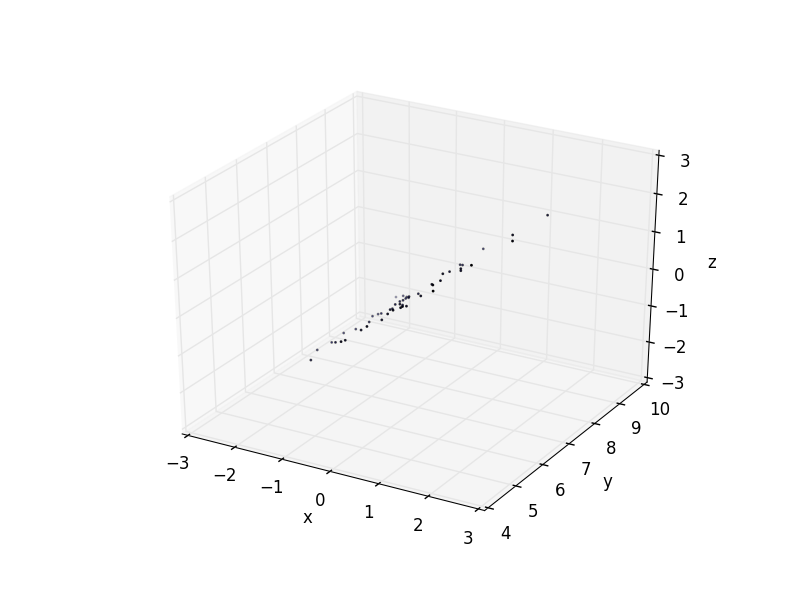

In [13]:
# plot train data, 3d
scatter_3d(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2],ys_train)

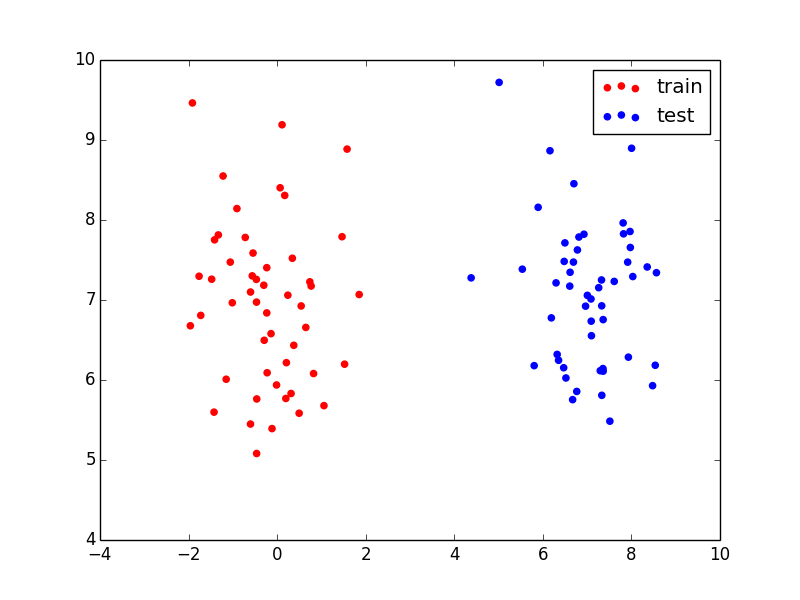

In [14]:
# plot train xs, test xs, 2d
fig, ax = plt.subplots()
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2], color='r', label='train')
ax.scatter(xs_test[:,xs_plot_dim_1],xs_test[:,xs_plot_dim_2], color='b', label='test')
ax.legend()
basic.display_fig_inline(fig)

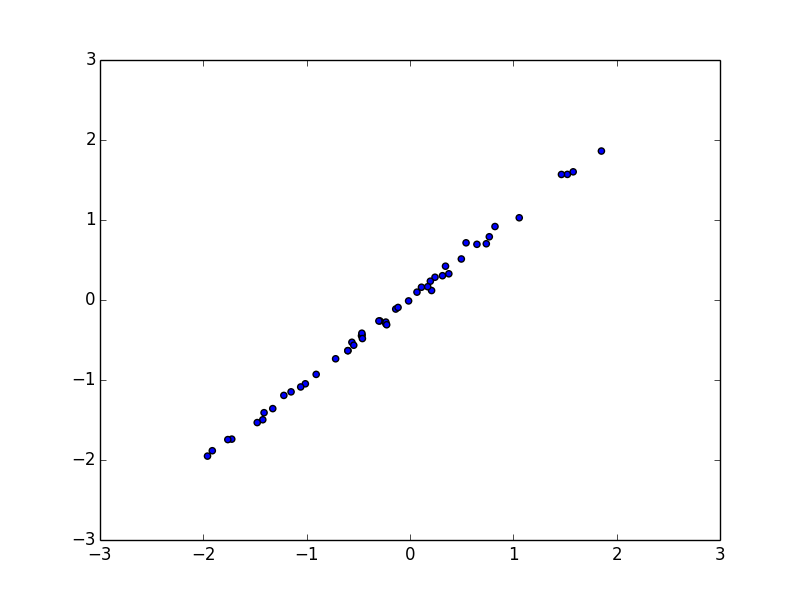

In [15]:
# plot data, 2d
scatter(plot_1d_us_train,ys_train)

In [16]:
# define stuff for SDR
#sigma = 0.1
#sigma = 0.5
sigma = 3.
SDR_get_K = functools.partial(kernels.get_gaussian_K, sigma)
SDR_eps = 0.01
#trace_from_ws_and_Ks = functools.partial(kernels.get_trace_from_ws_and_Ks, SDR_eps)
#trace_from_ws_and_Ks = lambda Ky, Ku, ws: np.dot(ws.T, ws) + kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, ws) # set ws to None here to turn off weighting of SDR

In [17]:
# define stuff for KMM
#B_max = 100
B_max = 10
KMM_eps = 0.01
KMM_get_K = SDR_get_K

In [18]:
#
def plot_weights(P):
    ws = kernels.get_KMM_ws_given_P(xs_train, xs_test, KMM_get_K, B_max, KMM_eps, P)
    fig, ax = plt.subplots()
    ax.scatter(ws, np.zeros(len(ws)), s=0.5)
    ax.set_title('obj: %.2f sum: %.2f' % (np.dot(ws.T,ws) / (num_train**2), np.sum(ws)))
    basic.display_fig_inline(fig)

In [19]:
# general stuff needed to calculate gradient

def f(get_K, B, P):
    
    # create K, kappa, use them to return objective fxn value
    
    import autograd, autograd.numpy as np
    
    us_train = np.dot(xs_train, P)
    us_test = np.dot(xs_test, P)
    K, kappa = kernels.get_KMM_params(us_train, us_test, get_K)
    
    return np.dot(np.dot(B.T, K), B)/2. + np.dot(kappa, B)

the_f = functools.partial(f, KMM_get_K)
df_dws = autograd.jacobian(the_f) # ans dim: |x|
d_dP_df_dws = autograd.jacobian(lambda p,x: df_dws(x,p)) # ans dim: |x| x |p|
d_dws_df_dws = autograd.jacobian(autograd.jacobian(the_f))

A, b = kernels.get_KMM_ineq_constraints(num_train, B_max, KMM_eps)

Ky = SDR_get_K(ys_train, ys_train)

tradeoff = 1.

#trace_from_ws_and_Ks = lambda Ky, Ku, ws: np.dot(ws.T, ws) + kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, ws) # set ws to None here to turn off weighting of SDR
#trace_from_ws_and_Ks = lambda Ky, Ku, ws: (tradeoff * np.dot(ws.T, ws)/float(num_train**2)) #+ kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, None) # set ws to None here to turn off weighting of SDR
trace_from_ws_and_Ks = lambda Ky, Ku, ws: kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, None) # set ws to None here to turn off weighting of SDR


dtrace_dwsopt = autograd.jacobian(lambda ws, Ky, Ku: trace_from_ws_and_Ks(Ky, Ku, ws))
def get_trace_from_P(trace_from_ws_and_Ks, xs_train, ys_train, SDR_get_K, SDR_eps, P, wsopt):
    us_train = np.dot(xs_train, P)
    #us_test = np.dot(xs_test, P)
    Ku = SDR_get_K(us_train, us_train)
    Ky = SDR_get_K(ys_train, ys_train)
    #Ku, kappau = kernels.get_KMM_params(us_train, us_test, shared_get_K)
    #wsopt = cvxopt_solver(Ku, kappau, A, b)
    return trace_from_ws_and_Ks(Ky, Ku, wsopt)
dtrace_dP_thru_Ku = autograd.jacobian(functools.partial(get_trace_from_P, trace_from_ws_and_Ks, xs_train, ys_train, SDR_get_K, SDR_eps))
#dtrace_dP_thru_Ku = autograd.jacobian(functools.partial(kernels.get_trace_from_P, xs_train, ys_train, SDR_get_K, SDR_eps))

In [20]:
# define some solvers
reg_lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
#lin_solver = lstsq_solver
#lin_solver = cg_solver
lin_solver = reg_lstsq_solver

In [21]:
# assemble obj f and gradient
d_trace_dP = functools.partial(kernels.get_dtrace_dP, xs_train, xs_test, Ky, SDR_get_K, dtrace_dP_thru_Ku, lin_solver, df_dws, d_dP_df_dws, d_dws_df_dws, dtrace_dwsopt, A, b)
trace = functools.partial(kernels.get_trace, trace_from_ws_and_Ks, xs_train, xs_test, Ky, KMM_get_K, lin_solver, A, b)

In [22]:
# set initial P:
#P_init = kernels.ortho(np.random.normal(size=(x_dim,v_dim)))
#P_init = kernels.ortho(np.array([[1.,0.]]).T)
#P_init = kernels.ortho(np.array([[1,-2.3]]).T)
#P_init = kernels.ortho(np.array([[0.,1.]]).T)
P_init = kernels.ortho(np.array([[0.19839015,0.98012313]]).T)

In [23]:
print xs_train

[[ 0.49671415  5.58462926]
 [-0.1382643   6.57935468]
 [ 0.64768854  6.65728548]
 [ 1.52302986  6.19772273]
 [-0.23415337  6.83871429]
 [-0.23413696  7.40405086]
 [ 1.57921282  8.8861859 ]
 [ 0.76743473  7.17457781]
 [-0.46947439  7.25755039]
 [ 0.54256004  6.92555408]
 [-0.46341769  5.08122878]
 [-0.46572975  6.97348612]
 [ 0.24196227  7.06023021]
 [-1.91328024  9.46324211]
 [-1.72491783  6.80763904]
 [-0.56228753  7.30154734]
 [-1.01283112  6.96528823]
 [ 0.31424733  5.83132196]
 [-0.90802408  8.14282281]
 [-1.4123037   7.75193303]
 [ 1.46564877  7.79103195]
 [-0.2257763   6.09061255]
 [ 0.0675282   8.40279431]
 [-1.42474819  5.59814894]
 [-0.54438272  7.58685709]
 [ 0.11092259  9.19045563]
 [-1.15099358  6.00946367]
 [ 0.37569802  6.43370227]
 [-0.60063869  7.09965137]
 [-0.29169375  6.49652435]
 [-0.60170661  5.44933657]
 [ 1.85227818  7.06856297]
 [-0.01349722  5.93769629]
 [-1.05771093  7.47359243]
 [ 0.82254491  6.08057577]
 [-1.22084365  8.54993441]
 [ 0.2088636   6.21674671]
 

In [24]:
print xs_test

[[ 7.32408397  7.25049285]
 [ 6.61491772  7.34644821]
 [ 6.323078    6.31997528]
 [ 7.61167629  7.2322537 ]
 [ 8.03099952  7.29307247]
 [ 7.93128012  6.28564858]
 [ 6.16078248  8.86577451]
 [ 6.69078762  7.47383292]
 [ 7.33126343  5.8086965 ]
 [ 7.97554513  7.65655361]
 [ 6.52082576  6.02531833]
 [ 6.81434102  7.7870846 ]
 [ 5.89366503  8.15859558]
 [ 5.80379338  6.17931768]
 [ 7.81252582  7.96337613]
 [ 8.35624003  7.41278093]
 [ 6.92798988  7.82206016]
 [ 8.0035329   8.89679298]
 [ 7.36163603  6.75461188]
 [ 6.35488025  6.24626384]
 [ 7.36139561  6.11048557]
 [ 8.53803657  6.18418972]
 [ 6.96417396  6.92289829]
 [ 8.56464366  7.34115197]
 [ 4.3802549   7.2766908 ]
 [ 7.8219025   7.82718325]
 [ 7.08704707  7.01300189]
 [ 6.70099265  8.45353408]
 [ 7.09176078  6.73534317]
 [ 5.01243109  9.72016917]
 [ 6.78032811  7.62566735]
 [ 7.35711257  6.14284244]
 [ 8.47789404  5.9291075 ]
 [ 6.48172978  7.48247242]
 [ 6.1915064   6.77653721]
 [ 6.49824296  7.71400049]
 [ 7.91540212  7.47323762]
 

In [25]:
KMM_get_K(np.dot(xs_train, P_init), np.dot(xs_train, P_init))

array([[ 1.        ,  0.9607485 ,  0.93711007, ...,  0.99768599,
         0.82370194,  0.91938451],
       [ 0.9607485 ,  1.        ,  0.99700635, ...,  0.97716845,
         0.9438973 ,  0.99196683],
       [ 0.93711007,  0.99700635,  1.        , ...,  0.95816317,
         0.96616364,  0.99877201],
       ..., 
       [ 0.99768599,  0.97716845,  0.95816317, ...,  1.        ,
         0.85738421,  0.94321681],
       [ 0.82370194,  0.9438973 ,  0.96616364, ...,  0.85738421,
         1.        ,  0.9776107 ],
       [ 0.91938451,  0.99196683,  0.99877201, ...,  0.94321681,
         0.9776107 ,  1.        ]])

In [26]:
# calculate numerical gradient at initial P
delta = 0.000001
dL_dP_val = np.zeros((x_dim, u_dim))
P1 = P_init
trace1 = trace(P_init)
for i in xrange(x_dim):
    for j in xrange(u_dim):
        delta_P_direction = np.zeros((x_dim, u_dim), dtype=float)
        delta_P_direction[i,j] = 1.
        P2 = P1 + (delta * delta_P_direction)
        trace2 = trace(P2)
        dL_dP_val[i,j] = (trace2 - trace1) / delta
print dL_dP_val
print dL_dP_val / np.linalg.norm(dL_dP_val)

[[-0.7753703 ]
 [ 0.13651848]]
[[-0.98485121]
 [ 0.17340152]]


In [27]:
us_train1 = xs_train.dot(P1)
us_test1 = xs_test.dot(P1)
the_get_KMM_ws = functools.partial(kernels.get_KMM_ws_given_P, xs_train, xs_test, KMM_get_K, B_max, KMM_eps)
ws1 = the_get_KMM_ws(P1)
Ku1 = SDR_get_K(us_train1, us_train1)
Ky = SDR_get_K(ys_train, ys_train)

# calculate gradient (thru wsopt) analytically, slowly
dws_dP_val1 = kernels.get_dxopt_dp(lin_solver, df_dws, d_dP_df_dws, d_dws_df_dws, A, b, ws1, P1)
dtrace_dwsopt_val1 = dtrace_dwsopt(ws1, Ky, Ku1)
np.sum(dws_dP_val1 * dtrace_dwsopt_val1[(slice(None),)+tuple([np.newaxis for i in xrange(len(P1.shape))])], axis=0)

solver error: 0.055906522715
solver error: 0.0104561936168


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/autograd/core.py:37: UserWarning: Output seems independent of input. Returning zero gradient.
  warnings.warn("Output seems independent of input. Returning zero gradient.")


array([[ 0.],
       [ 0.]])

In [28]:
# calculate analytic gradient at initial P
anal_val = d_trace_dP(P_init)
print anal_val
print anal_val / np.linalg.norm(anal_val)

C rank 38 (65, 65)
solver error: 0.0
[[-0.77536444]
 [ 0.13651889]]
[[-0.9848509]
 [ 0.1734033]]


C rank 100 (100, 100)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0
C rank 99 (99, 99)
solver error: 0.0


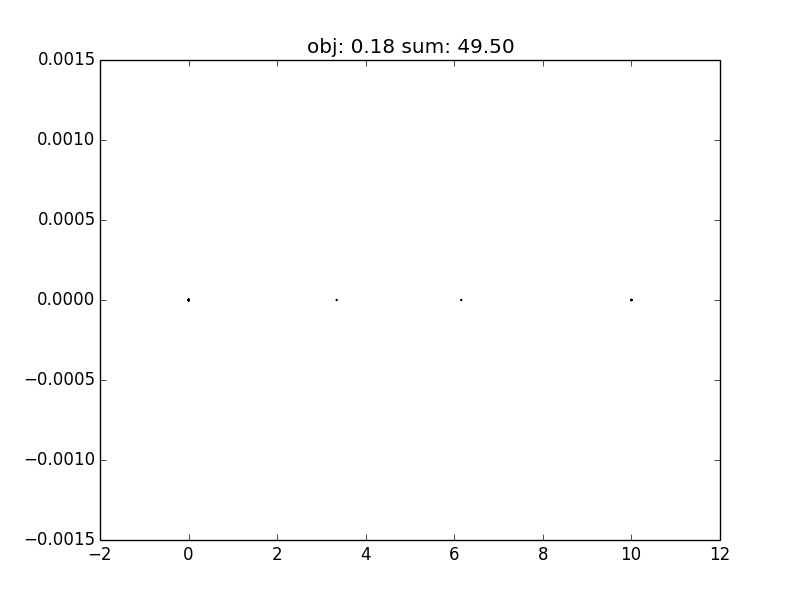

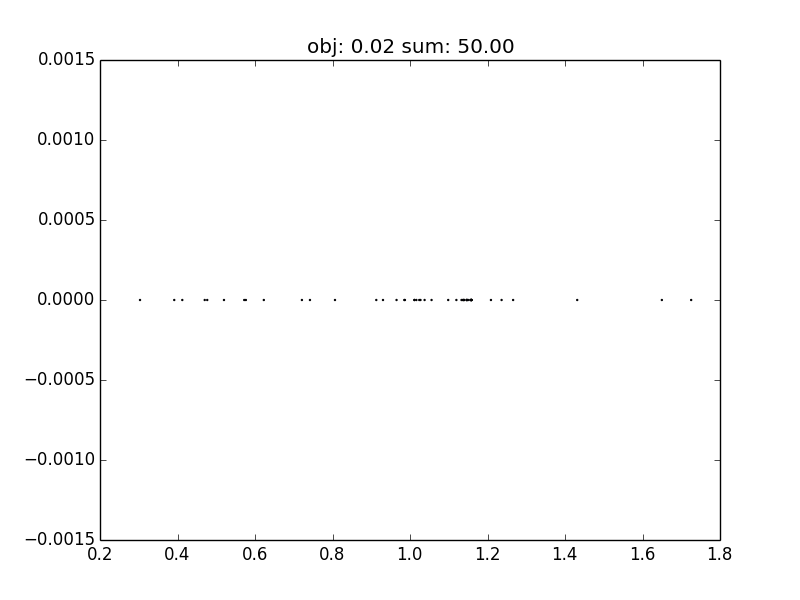

P_fit: [[-0.99998935]
 [ 0.00461418]]
P_true: [[ 0.]
 [ 1.]]
And here comes the optlog:

{'final_values': {'f(x)': 1.4069470956899193,
                  'gradnorm': 2.6290167782493455e-07,
                  'iterations': 14,
                  'stepsize': 2.8504973715725169e-08,
                  'time': 1.5689129829406738,
                  'x': array([[-0.99998935],
       [ 0.00461418]])},
 'iterations': {'f(x)': [3.9181596522675775,
                         1.6320379443121591,
                         1.4194752377571651,
                         1.407001079273831,
                         1.4069820136935969,
                         1.4069473932518459,
                         1.4069472947212804,
                         1.4069470957093488,
                         1.4069470956911339,
                         1.4069470956908419,
                         1.4069470956900427,
                         1.4069470956899617,
                         1.4069470956899499,
                     

In [29]:
# do gradient descent
from pymanopt import Problem
from pymanopt.solvers import SteepestDescent
from pymanopt.manifolds import Stiefel
solver = pymanopt.solvers.SteepestDescent(logverbosity=2)
#solver = pymanopt.solvers.ConjugateGradient(logverbosity=2)
#solver = pymanopt.solvers.NelderMead(logverbosity=2)
#solver = pymanopt.solvers.ParticleSwarm(logverbosity=2)
manifold = pymanopt.manifolds.Stiefel(x_dim, u_dim)
#manifold = pymanopt.manifolds.Grassmann(x_dim, u_dim)
problem = pymanopt.Problem(manifold=manifold, cost=trace, egrad=d_trace_dP, verbosity=0)
#P_fit, opt_log = solver.solve(problem, x=P_init)
P_fit, opt_log = solver.solve(problem)
plot_weights(P_fit)
plot_weights(v_bases)
print 'P_fit:', P_fit
print 'P_true:', v_bases
print('And here comes the optlog:\n\r')
pp = pprint.PrettyPrinter()
pp.pprint(opt_log)

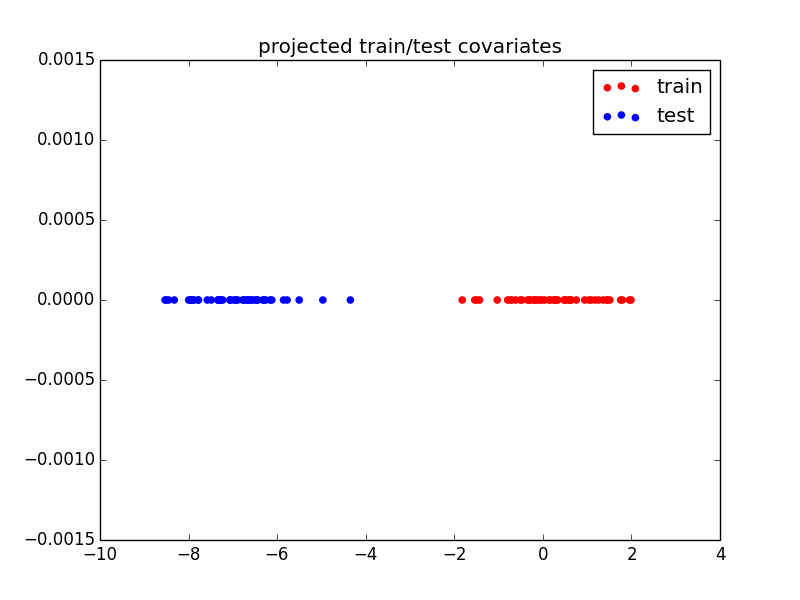

In [33]:
# plot projected train and test
fig, ax = plt.subplots()
ss_train = xs_train.dot(P_fit)
ss_test = xs_test.dot(P_fit)
if P_fit.shape[1] == 1:
    ax.scatter(ss_train, np.zeros(len(ss_train)), color='r', label='train')
    ax.scatter(ss_test, np.zeros(len(ss_test)), color='b', label='test')
    ax.set_title('projected train/test covariates')
    ax.legend()
    basic.display_fig_inline(fig)
elif P_fit.shape[1] == 2:
    ax.scatter(ss_train[:,0], ss_train[:,1], color='r', label='train')
    ax.scatter(ss_test[:,0], ss_test[:,1], color='b', label='test')
    ax.set_title('projected train/test covariates')
    ax.legend()
    basic.display_fig_inline(fig)
else:
    assert False

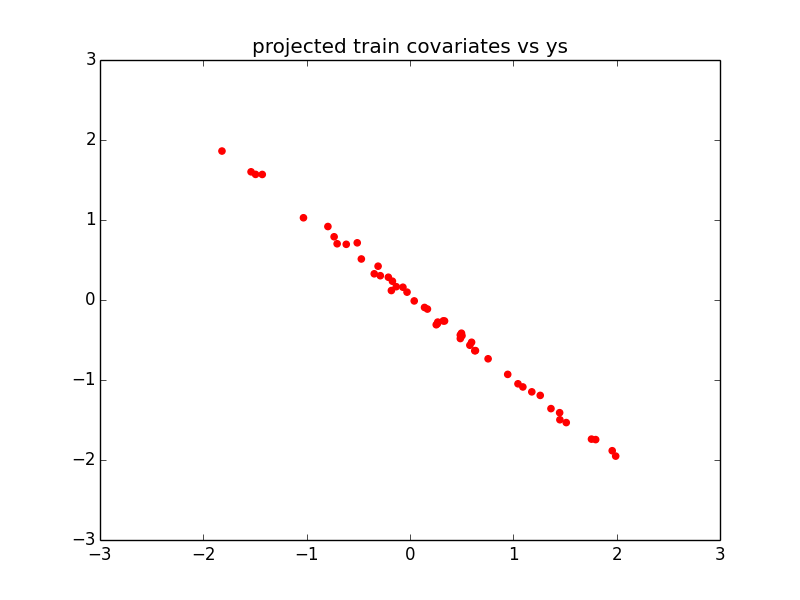

In [31]:
# plot ys_train against projected xs_train
if P_fit.shape[1] == 1:
    fig, ax = plt.subplots()
    ax.scatter(ss_train, ys_train, color='r', label='train')
    ax.set_title('projected train covariates vs ys')
    basic.display_fig_inline(fig)
elif P_fit.shape[1] == 2:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ss_train[:,0],ss_train[:,1],ys,s=1)
    ax.set_xlabel('s1')
    ax.set_ylabel('s2')
    ax.set_zlabel('y')
    basic.display_fig_inline(fig)

In [32]:
assert False

AssertionError: 